# **ViTs para Agave – De Software a Hardware**


### Integrantes del equipo N° #31:
- Arian Yolanda Reyes Aguilar - A01795124
- Oscar Nava Jiménez - A01745524
- Bruno Sánchez García - A01378960

### Asesor del Proyecto: Diego Concepción Villatoro Gerónimo

### Director del Proyecto: Luis Eduardo Falcón Morales
### Proyecto Integrador | Fecha de Entrega: 19/10/2025

### **Propósito de Proyecto**
El proyecto tiene como objetivo implementar y validar un modelo de visión
computacional basado en Vision Transformers (ViTs) para detectar
automáticamente plantas de agave y evaluar su estado de salud mediante
imágenes capturadas en campo. El modelo, desarrollado en PyTorch bajo la
arquitectura bit-STED, ya ha sido probado exitosamente en software. Ahora se
busca llevarlo a una plataforma embebida, específicamente una Raspberry Pi 5,
para evaluar su rendimiento, eficiencia y viabilidad en condiciones reales con
recursos limitados. Esta prueba en hardware permitirá determinar si la solución
es apta para su implementación directa en el entorno agrícola.

### **Contexto sobre Imagenes**

El dataset consta de aproximadamente 2440 imágenes multiespectrales de tamaño 224x224 píxeles, capturadas en cinco campos agrícolas diferentes. Cada imagen está compuesta por múltiples bandas espectrales que incluyen azul (450 nm), verde (560 nm), rojo (650 nm), borde rojo (730 nm) y el infrarrojo cercano (840 nm). Estas imágenes fueron tomadas con drones equipados con sensores especializados, y están destinadas a permitir el análisis detallado de plantas de agave mediante técnicas de visión por computadora. El formato de las imágenes es TIFF multibanda, lo que permite conservar la información espectral necesaria para detectar y evaluar el estado de salud de las plantas.

### **Objetivo de Actividad**

El objetivo de esta actividad es explorar, construir y evaluar una gama diversa de modelos de aprendizaje automático individuales aplicados a la tarea de detección y clasificación del estado de salud de plantas de agave a partir de imágenes recolectadas en campo. Esta evaluación tiene como propósito identificar el modelo que ofrece el mejor rendimiento en términos de precisión, eficiencia y viabilidad para ser implementado en una plataforma embebida como la Raspberry Pi 5. Para ello, se entrenarán e implementarán al menos seis modelos diferentes, se compararán mediante métricas cuantitativas de desempeño y, posteriormente, se ajustarán los hiperparámetros de los dos modelos más prometedores para seleccionar el modelo final más adecuado.

Importación de Librerías y Configuración de Rutas

In [39]:
import os
import torch
import torchvision.transforms as T
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tifffile import imread
from PIL import Image, ImageDraw
from model.transformer import TransformerObjectDetection
import utils.counting
from ultralytics import YOLO
from ultralytics import RTDETR
import cv2
from pathlib import Path
import random
import time
import pandas as pd
import seaborn as sns


Funcion para Leer Etiquetas

In [2]:
def leer_etiquetas_yolo(path_txt, img_ancho, img_alto):
    """
    Lee un archivo de etiquetas en formato YOLO y devuelve las cajas en 
    coordenadas absolutas escaladas al tamaño del modelo (por defecto 224x224).

    El formato YOLO esperado por línea es:
        class_id x_center y_center width height

    Donde las coordenadas están normalizadas en el rango [0, 1].

    Parámetros
    ----------
    path_txt : str o Path
        Ruta del archivo .txt con las etiquetas YOLO correspondientes a la imagen.
    img_ancho : int
        Ancho original de la imagen en píxeles.
    img_alto : int
        Alto original de la imagen en píxeles.

    Retorna
    -------
    list[list[float]]
        Lista de cajas en formato [x1, y1, x2, y2], escaladas a 224x224 píxeles.

    Ejemplo
    --------
    >>> leer_etiquetas_yolo("ejemplo.txt", 1920, 1080)
    [[54.2, 80.5, 120.6, 150.3], [130.1, 90.4, 180.2, 160.9]]
    """
    cajas = []

    # Abrir y leer el archivo línea por línea
    with open(path_txt, "r") as f:
        for linea in f:
            partes = linea.strip().split()
            if len(partes) == 5:
                # Desempaquetar: clase, centro (x, y) y tamaño (w, h)
                _, x_center, y_center, w, h = map(float, partes)

                # Convertir de normalizado (0–1) a absoluto (px)
                x_center_abs = x_center * img_ancho
                y_center_abs = y_center * img_alto
                w_abs = w * img_ancho
                h_abs = h * img_alto

                # Calcular esquinas (x1, y1, x2, y2)
                x1 = x_center_abs - w_abs / 2
                y1 = y_center_abs - h_abs / 2
                x2 = x_center_abs + w_abs / 2
                y2 = y_center_abs + h_abs / 2

                cajas.append([x1, y1, x2, y2])

    # Escalar a tamaño de entrada del modelo (224x224)
    modelo_ancho, modelo_alto = 224, 224
    cajas_escaladas = [
        [
            x1 * modelo_ancho / img_ancho,
            y1 * modelo_alto / img_alto,
            x2 * modelo_ancho / img_ancho,
            y2 * modelo_alto / img_alto
        ]
        for (x1, y1, x2, y2) in cajas
    ]

    return cajas_escaladas

Funcion para Convertir Circulos a Cajas

In [ ]:
def convertir_circulos_a_cajas(circulos):
    """
    Convierte una lista de círculos en cajas delimitadoras (bounding boxes)
    en formato [x1, y1, x2, y2].

    Cada círculo se representa por su centro (xc, yc) y su radio (r).  
    La conversión genera una caja cuadrada que encierra completamente el círculo.

    Parámetros
    ----------
    circulos : list[list[float]] o list[tuple[float]]
        Lista de círculos, donde cada elemento tiene el formato [xc, yc, r],
        con coordenadas en píxeles o valores normalizados.

    Retorna
    -------
    list[list[float]]
        Lista de cajas delimitadoras, cada una en formato [x1, y1, x2, y2].

    Ejemplo
    --------
    >>> convertir_circulos_a_cajas([[50, 50, 10], [100, 75, 5]])
    [[40, 40, 60, 60], [95, 70, 105, 80]]
    """

    # Cada círculo (xc, yc, r) se convierte en caja:
    #   x1 = xc - r → esquina superior izquierda (x)
    #   y1 = yc - r → esquina superior izquierda (y)
    #   x2 = xc + r → esquina inferior derecha (x)
    #   y2 = yc + r → esquina inferior derecha (y)
    return [[xc - r, yc - r, xc + r, yc + r] for (xc, yc, r) in circulos]


Funcion para Calcular IOU

In [4]:
def calcular_iou(cajaA, cajaB):
    """
    Calcula la Intersección sobre Unión (IoU, *Intersection over Union*)
    entre dos cajas delimitadoras.

    La IoU mide cuánto se solapan dos cajas de detección, dividiendo el
    área de su intersección entre el área total (unión) de ambas.

    Parámetros
    ----------
    cajaA : list[float] o tuple[float]
        Coordenadas de la primera caja en formato [x1, y1, x2, y2].
    cajaB : list[float] o tuple[float]
        Coordenadas de la segunda caja en formato [x1, y1, x2, y2].

    Retorna
    -------
    float
        Valor de IoU en rango [0, 1].
        - 0 indica que no hay solapamiento.
        - 1 indica coincidencia completa entre ambas cajas.

    Ejemplo
    --------
    >>> calcular_iou([0, 0, 100, 100], [50, 50, 150, 150])
    0.1428
    """

    # ------------------------------------------------------------
    # Coordenadas del área de intersección (rectángulo común)
    # ------------------------------------------------------------
    xA = max(cajaA[0], cajaB[0])  # Punto superior izquierdo (x)
    yA = max(cajaA[1], cajaB[1])  # Punto superior izquierdo (y)
    xB = min(cajaA[2], cajaB[2])  # Punto inferior derecho (x)
    yB = min(cajaA[3], cajaB[3])  # Punto inferior derecho (y)

    # ------------------------------------------------------------
    # Calcular área de intersección (ancho × alto)
    # ------------------------------------------------------------
    inter = max(0, xB - xA) * max(0, yB - yA)

    # ------------------------------------------------------------
    # Calcular áreas individuales de cada caja
    # ------------------------------------------------------------
    areaA = (cajaA[2] - cajaA[0]) * (cajaA[3] - cajaA[1])
    areaB = (cajaB[2] - cajaB[0]) * (cajaB[3] - cajaB[1])

    # ------------------------------------------------------------
    # Calcular área de la unión
    # ------------------------------------------------------------
    union = areaA + areaB - inter

    # ------------------------------------------------------------
    # IoU = intersección / unión
    # (1e-6 evita división por cero)
    # ------------------------------------------------------------
    return inter / (union + 1e-6)


Funcion para Calcular Metricas

In [5]:
def calcular_metricas(gt_cajas, pred_cajas, iou_umbral=0.5):
    """
    Calcula las métricas de detección: Precisión, Recall y F1-score
    basadas en la coincidencia entre las cajas de verdad de terreno (GT)
    y las predicciones del modelo, utilizando un umbral de IoU.

    Parámetros
    ----------
    gt_cajas : list[list[float]]
        Lista de cajas de verdad de terreno (ground truth) en formato
        [x1, y1, x2, y2].
    pred_cajas : list[list[float]]
        Lista de cajas predichas por el modelo en el mismo formato.
    iou_umbral : float, opcional
        Valor mínimo de intersección sobre unión (IoU) para considerar
        una predicción como verdadera positiva. Por defecto es 0.5.

    Retorna
    -------
    tuple
        (precision, recall, f1) — métricas de evaluación en rango [0, 1].
    """

    # Contador de verdaderos positivos
    TP = 0

    # Conjuntos para registrar coincidencias (evita doble conteo)
    gt_usadas = set()
    pred_usadas = set()

    # ------------------------------------------------------------------
    # Comparar cada caja GT con las predicciones
    # ------------------------------------------------------------------
    for i, gt in enumerate(gt_cajas):
        for j, pred in enumerate(pred_cajas):

            # Saltar si la predicción ya fue emparejada
            if j in pred_usadas:
                continue

            # Calcular IoU entre caja GT y predicha
            if calcular_iou(gt, pred) >= iou_umbral:
                TP += 1
                gt_usadas.add(i)
                pred_usadas.add(j)
                break  # Solo se empareja una predicción por GT

    # ------------------------------------------------------------------
    # Cálculo de métricas
    # ------------------------------------------------------------------
    FP = len(pred_cajas) - len(pred_usadas)  # Falsos positivos
    FN = len(gt_cajas) - len(gt_usadas)      # Falsos negativos

    # Precisión: proporción de detecciones correctas sobre todas las predicciones
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Recall: proporción de detecciones correctas sobre las cajas reales
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1-score: media armónica entre precisión y recall
    f1 = (
        2 * precision * recall / (precision + recall)
        if (precision + recall) > 0 else 0
    )

    return precision, recall, f1

Funcion para Dibujar Resultados

In [6]:

def dibujar_resultados(img, gt_cajas, pred_cajas, titulo="Resultados", ax=None):
    """
    Dibuja las cajas Ground Truth (verde) y Predichas (rojo) sobre una imagen PNG.
    Compatible con el formato de imágenes usado por YOLO (uint8, 3 canales).

    Parámetros
    ----------
    img : np.ndarray
        Imagen en formato (H, W, 3), uint8 o float32, cargada desde archivo PNG.
    gt_cajas : list[list[float]]
        Cajas de verdad de terreno en formato [x1, y1, x2, y2].
    pred_cajas : list[list[float]]
        Cajas predichas por el modelo en formato [x1, y1, x2, y2].
    titulo : str, opcional
        Título del gráfico.
    ax : matplotlib.axes.Axes, opcional
        Eje sobre el cual dibujar. Si es None, se crea una nueva figura.
    """

    # Crear eje si no se proporciona
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Convertir BGR → RGB si la imagen proviene de OpenCV
    if img.ndim == 3 and img.shape[2] == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = np.stack([img] * 3, axis=-1) if img.ndim == 2 else img

    # Mostrar imagen
    ax.imshow(img_rgb)
    ax.set_title(titulo)
    ax.axis("off")

    # Dibujar cajas Ground Truth (verde)
    for (x1, y1, x2, y2) in gt_cajas:
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='lime', facecolor='none', label='Ground Truth'
        )
        ax.add_patch(rect)

    # Dibujar cajas Predichas (rojo punteado)
    for (x1, y1, x2, y2) in pred_cajas:
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Predicción'
        )
        ax.add_patch(rect)

    # Crear leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), loc='upper right', fontsize=8, framealpha=0.6)

    if ax is None:
        plt.tight_layout()
        plt.show()

Cargar Imagenes y Etiquetas

In [ ]:
# ================================================================
# Definición de rutas
# ================================================================
IMAGES_DIR = Path("Zones_cbbox_dataset_10/val/images")
LABELS_DIR = Path("Zones_cbbox_dataset_10/val/labels")

# Buscar todos los archivos .png y .txt
imagenes = sorted(IMAGES_DIR.glob("*.png"))
etiquetas = sorted(LABELS_DIR.glob("*.txt"))

# Mostrar conteo de archivos
print(f"🖼️ Total de imágenes PNG: {len(imagenes)}")
print(f"📄 Total de etiquetas TXT: {len(etiquetas)}")

# ================================================================
# Probar una sola imagen
# ================================================================
nombre_imagen = '0115.png'
ruta_imagen = IMAGES_DIR / nombre_imagen
ruta_etiqueta = LABELS_DIR / (Path(nombre_imagen).stem + '.txt')

# Leer imagen como RGB
imagen = cv2.imread(str(ruta_imagen))
if imagen is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta_imagen}")
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Obtener dimensiones
alto, ancho = imagen.shape[:2]

# Convertir a tensor PyTorch [1, 3, H, W]
imagen_tensor = torch.tensor(imagen, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

# Leer etiquetas en formato YOLO
gt_cajas = leer_etiquetas_yolo(ruta_etiqueta, ancho, alto)

🖼️ Total de imágenes PNG: 1377
📄 Total de etiquetas TXT: 1377


Configuracion de Dispositivo

In [ ]:
# Selección automática de GPU o CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

# Configuración general de visualización
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10

# Función auxiliar para mostrar información del entorno
def info_entorno():
    print("=" * 60)
    print("Versión de PyTorch:", torch.__version__)
    print("CUDA disponible:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("Dispositivo CUDA:", torch.cuda.get_device_name(0))
    print("=" * 60)

# Mostrar información al inicio
info_entorno()

Cargando el Modelo Bit-STED

In [ ]:
# ================================================================
# Inferencia y evaluación del modelo Bit-STED
# ================================================================

# Seleccionar dispositivo
device = torch.device( 'cpu')

# Inicializar modelo Bit-STED
modelo_bit = TransformerObjectDetection(
    image_size=224,
    N_channels=3,
    n_model=128,
    num_blks=1,
    obj='cbbox',
    device=device,
    bitNet=True
).to(device)

# Cargar pesos entrenados
checkpoint_path = 'best.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)
modelo_bit.load_state_dict(
    checkpoint['model'] if isinstance(checkpoint, dict) and 'model' in checkpoint else checkpoint
)
modelo_bit.eval()

# Inferencia sobre la imagen
boxes_bit, scores_bit, _, _ = utils.counting.inference(
    modelo_bit,
    imagen_tensor.to(device),
    'cbbox',
    conf_thr=0.4,
    diou_thr=0.5
)

# Convertir predicciones (círculos [xc, yc, r]) a cajas [x1, y1, x2, y2]
boxes_bit_np = boxes_bit[0].cpu().numpy()
pred_cajas_bit = convertir_circulos_a_cajas(boxes_bit_np)

# Calcular métricas de desempeño (Precisión, Recall, F1)
precision, recall, f1 = calcular_metricas(gt_cajas, pred_cajas_bit)
print(f"Bit-STED → Precisión: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

Bit-STED → Precisión: 1.000 | Recall: 0.778 | F1: 0.875


C:\Users\BSG\AppData\Local\Temp\ipykernel_33676\2882398996.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Bit-STED mostró una precisión perfecta, lo que indica que no cometió falsos positivos. Sin embargo, su valor de recall revela que dejó pasar algunos casos reales de plantas de agave. Aun así, alcanzó el F1 Score más alto entre todos los modelos, destacándose por su equilibrio general con una fuerte inclinación hacia la precisión.

Cargando el Modelo YOLOv8 Nano

In [10]:
# Cargar modelo YOLOv8
modelo_yolo_v8n = YOLO("yolov8n100e_custom.pt")

# ============================================================
# Inferencia
# ============================================================
resultados = modelo_yolo_v8n.predict(
    source=ruta_imagen,
    imgsz=224,
    conf=0.5,
    verbose=False
)[0]

# ============================================================
# Extraer cajas predichas
# ============================================================
# Cada resultado contiene .boxes con coordenadas [x1, y1, x2, y2]
pred_cajas_v8n = resultados.boxes.xyxy.cpu().numpy().tolist() if resultados.boxes is not None else []

# ============================================================
# 6. Evaluar métricas personalizadas
# ============================================================
p, r, f1 = calcular_metricas(gt_cajas, pred_cajas_v8n)
print("YOLOv8Nano:", f"Precisión: {p:.3f}", f"Recall: {r:.3f}", f"F1: {f1:.3f}")

YOLOv8Nano: Precisión: 0.750 Recall: 0.667 F1: 0.706


YOLOv8 Nano fue el modelo con el rendimiento más bajo. Presentó tanto una menor precisión como un recall reducido, lo que sugiere que tuvo dificultades para detectar y clasificar correctamente las plantas de agave, probablemente debido a su arquitectura ligera optimizada para velocidad más que para precisión.

Cargando el Modelo YOLOv8 Small

In [11]:

# Cargando modelo 
modelo_yolo_v8s = YOLO('yolov8s100e_custom.pt')

# ============================================================
# Inferencia
# ============================================================

resultados = modelo_yolo_v8s.predict(
    source=ruta_imagen, 
    imgsz=224, 
    conf=0.5, 
    verbose=False)[0]

# ============================================================
# Extraer cajas predichas
# ============================================================
# Cada resultado contiene .boxes con coordenadas [x1, y1, x2, y2]

pred_cajas_v8s = resultados.boxes.xyxy.cpu().numpy().tolist()


# ============================================================
# Evaluar métricas personalizadas
# ============================================================

p, r, f1 = calcular_metricas(gt_cajas, pred_cajas_v8s)
print("YOLOv8 Small:", f"Precisión: {p:.3f}", f"Recall: {r:.3f}", f"F1: {f1:.3f}")

YOLOv8 Small: Precisión: 0.875 Recall: 0.778 F1: 0.824


Este modelo ofreció un buen equilibrio entre rendimiento y eficiencia. Sus métricas indican una capacidad sólida de detección con pocos falsos positivos y pocos casos omitidos.

Cargando el Modelo RT-DETR (Detection Transformer)

In [12]:
# Cargar el modelo RT-DETR
modelo_detr = RTDETR("rtdetr_l_15ecustom.pt")

# ============================================================
# Inferencia
# ============================================================
results = modelo_detr.predict(
    source=ruta_imagen,
    conf=0.5,
    imgsz=224, 
    verbose=False)

# ============================================================
# Extraer cajas predichas
# ============================================================
# Cada resultado contiene .boxes con coordenadas [x1, y1, x2, y2]
pred_cajas_detr = results[0].boxes.xyxy.cpu().numpy().tolist() if resultados.boxes is not None else []

# ============================================================
# Evaluar métricas personalizadas
# ============================================================
p, r, f1 = calcular_metricas(gt_cajas, pred_cajas_detr)
print("RT-DETR:", f"Precisión: {p:.3f}", f"Recall: {r:.3f}", f"F1: {f1:.3f}")


RT-DETR: Precisión: 0.778 Recall: 0.778 F1: 0.778


RT-DETR mostró un rendimiento equilibrado en todas las métricas, sin puntos débiles ni destacados. Su consistencia lo convierte en una opción fiable en escenarios donde se prioriza la estabilidad del modelo por encima del máximo rendimiento.

Cargando el Modelo YOLOv5 Small

In [13]:
# Cargar el modelo
modelo_yolo_v5s = YOLO("yolov5s_15ecustom.pt")

# ============================================================
# Inferencia
# ============================================================
results = modelo_yolo_v5s.predict(
    source=ruta_imagen,
    conf=0.5,
    imgsz=224, 
    verbose=False)

# ============================================================
# Extraer cajas predichas
# ============================================================
# Cada resultado contiene .boxes con coordenadas [x1, y1, x2, y2]
pred_cajas_v5s = results[0].boxes.xyxy.cpu().numpy().tolist() if resultados.boxes is not None else []

# ============================================================
# Evaluar métricas personalizadas
# ============================================================
p, r, f1 = calcular_metricas(gt_cajas, pred_cajas_v5s)
print("YOLOv5Small:", f"Precisión: {p:.3f}", f"Recall: {r:.3f}", f"F1: {f1:.3f}")

YOLOv5Small: Precisión: 0.875 Recall: 0.778 F1: 0.824


Al igual que YOLOv8 Small, este modelo demostró una alta precisión y recall. Sus resultados reflejan una capacidad robusta para la detección de objetos, siendo adecuado para su implementación en condiciones reales.

Cargando el Modelo YOLOv11 Nano

In [16]:
# Cargar el modelo
modelo_yolo_v11n = YOLO("yolo11n_10ecustom.pt")

# ============================================================
# Inferencia
# ============================================================
results = modelo_yolo_v5s.predict(
    source=ruta_imagen,
    conf=0.5,
    imgsz=224, 
    verbose=False)

# ============================================================
# Extraer cajas predichas
# ============================================================
# Cada resultado contiene .boxes con coordenadas [x1, y1, x2, y2]
pred_cajas_v11n = results[0].boxes.xyxy.cpu().numpy().tolist() if resultados.boxes is not None else []

# ============================================================
# Evaluar métricas personalizadas
# ============================================================
p, r, f1 = calcular_metricas(gt_cajas, pred_cajas_v11n)
print("YOLOv11Nano:", f"Precisión: {p:.3f}", f"Recall: {r:.3f}", f"F1: {f1:.3f}")

YOLOv11Nano: Precisión: 0.875 Recall: 0.778 F1: 0.824


YOLOv11 Nano logró un rendimiento comparable a las versiones Small de YOLOv5 y YOLOv8. Sus métricas indican una mejora significativa respecto a YOLOv8 Nano, manteniendo una estructura liviana que lo hace potencialmente eficiente para sistemas embebidos.

Visualización de los Modelos

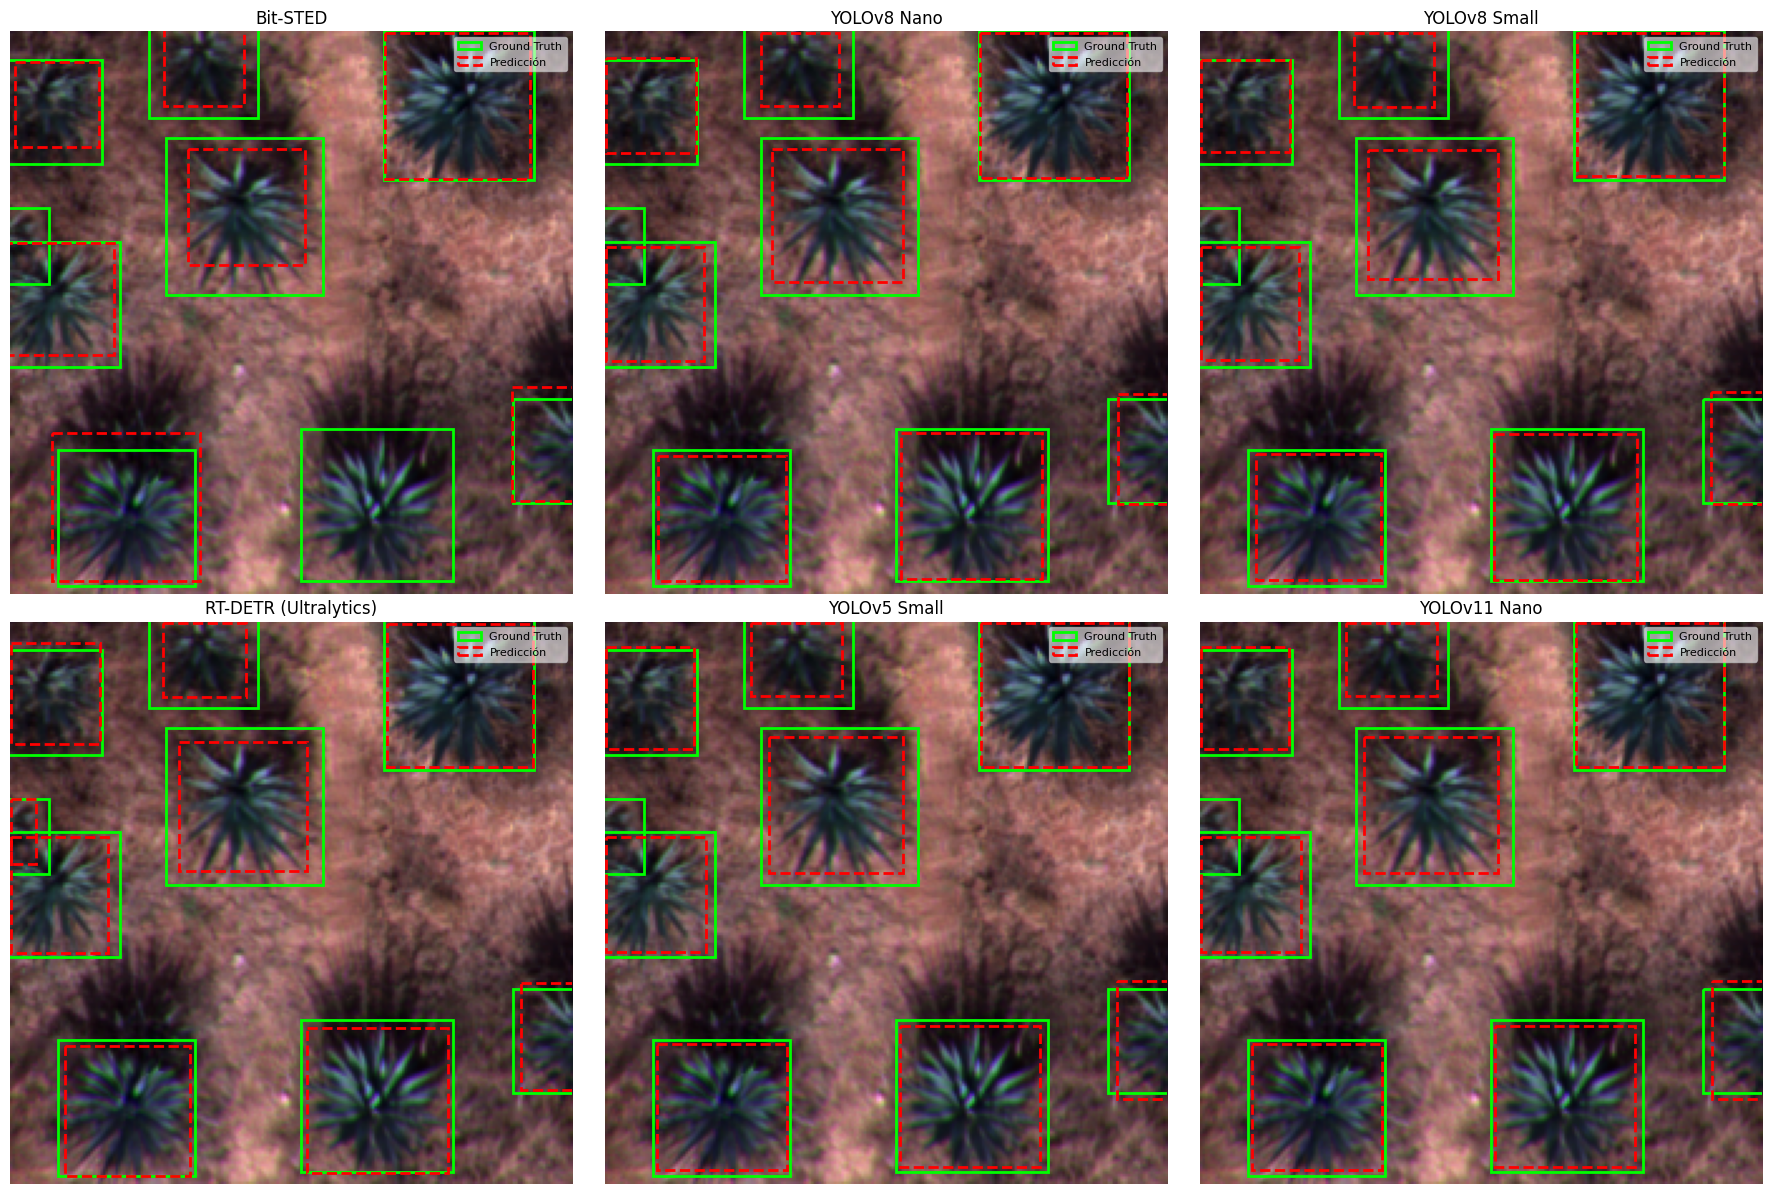

In [ ]:
# Crear figura
fig, ejes = plt.subplots(2, 3, figsize=(18, 12))
ejes = ejes.flatten()

titulos = [
    "Bit-STED",
    "YOLOv8 Nano",
    "YOLOv8 Small",
    "RT-DETR (Ultralytics)",
    "YOLOv5 Small",
    "YOLOv11 Nano"
]

predicciones = [
    pred_cajas_bit,
    pred_cajas_v8n,
    pred_cajas_v8s,
    pred_cajas_detr,
    pred_cajas_v5s,
    pred_cajas_v11n
]

# Dibujar resultados en subplots
for eje, titulo, preds in zip(ejes, titulos, predicciones):
    dibujar_resultados(imagen, gt_cajas, preds, titulo=titulo, ax=eje)

plt.tight_layout()
plt.show()

Las imágenes muestran una comparación visual de seis modelos de detección de objetos: Bit-STED, YOLOv8 Nano, YOLOv8 Small, RT-DETR, YOLOv5 Small y YOLOv11 Nano, aplicados a la detección de plantas de agave en imágenes aéreas de campo. Cada subimagen presenta las cajas delimitadoras predichas por el modelo, representadas con líneas discontinuas, superpuestas a las anotaciones de referencia, que están en líneas continuas verdes. Bit-STED destaca por una alineación casi perfecta entre las predicciones y la verdad de terreno, reflejando su alta precisión. Por otro lado, YOLOv8 Nano muestra varias detecciones omitidas y falsos positivos, indicando un rendimiento inferior. Los modelos YOLOv5 Small, YOLOv8 Small y YOLOv11 Nano presentan predicciones fuertes y consistentes, con la mayoría de las cajas delimitadoras cubriendo con precisión las plantas de agave. RT-DETR muestra una precisión moderada, con algunas cajas ligeramente desalineadas. En general, este análisis visual complementa los resultados cuantitativos y resalta las fortalezas relativas de los modelos para detectar plantas de agave en condiciones reales de campo.

In [ ]:
# ================================================================
# Evaluación comparativa de los 6 modelos (Bit-STED + YOLO + RT-DETR)
# ================================================================

# ------------------------------------------------
# Función genérica para evaluar un modelo Ultralytics
# ------------------------------------------------
def evaluar_modelo_ultralytics(modelo, lista_imagenes, etiquetas_dir, iou_umbral=0.5, conf=0.25):
    """
    Evalúa un modelo Ultralytics (YOLOv5, YOLOv8, RT-DETR, YOLO11, etc.)
    sobre un conjunto de validación usando las etiquetas en formato YOLO.

    Parámetros:
    ----------
    modelo : ultralytics.YOLO
        Modelo entrenado de la librería Ultralytics.
    lista_imagenes : list[str]
        Lista de rutas de las imágenes de validación (PNG).
    etiquetas_dir : str
        Directorio que contiene los archivos .txt de las etiquetas YOLO.
    iou_umbral : float
        Umbral IoU mínimo para considerar una detección verdadera.
    conf : float
        Umbral de confianza para filtrar predicciones.

    Retorna:
    -------
    tuple(float, float, float)
        Promedios de precisión, recall y F1-score del modelo.
    """
    precisiones, recalls, f1s = [], [], []

    for img_path in lista_imagenes:
        nombre = Path(img_path).stem
        label_path = Path(etiquetas_dir) / f"{nombre}.txt"
        if not label_path.exists():
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            continue

        h, w = img.shape[:2]
        gt_cajas = leer_etiquetas_yolo(label_path, w, h)

        # Ultralytics realiza el reescalado y normalización internamente
        resultados = modelo.predict(source=img, imgsz=224, conf=conf, verbose=False)[0]
        pred_cajas = resultados.boxes.xyxy.cpu().numpy().tolist() if resultados.boxes is not None else []

        p, r, f1 = calcular_metricas(gt_cajas, pred_cajas, iou_umbral)
        precisiones.append(p)
        recalls.append(r)
        f1s.append(f1)

    return np.mean(precisiones), np.mean(recalls), np.mean(f1s)


# ------------------------------------------------
# Función para evaluar el modelo Bit-STED
# ------------------------------------------------
def evaluar_modelo_bitsted(modelo, lista_imagenes, etiquetas_dir, iou_umbral=0.5, conf=0.4, diou=0.5):
    """
    Evalúa el modelo Bit-STED con preprocesamiento compatible:
    - Conversión BGR→RGB
    - Redimensionado a 224×224
    - Normalización explícita a [0, 1]
    """
    precisiones, recalls, f1s = [], [], []

    for img_path in lista_imagenes:
        nombre = Path(img_path).stem
        label_path = Path(etiquetas_dir) / f"{nombre}.txt"
        if not label_path.exists():
            continue

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            continue

        h, w = img_bgr.shape[:2]
        gt_cajas = leer_etiquetas_yolo(label_path, w, h)

        # Preprocesamiento
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb_224 = cv2.resize(img_rgb, (224, 224), interpolation=cv2.INTER_AREA)
        img_f32 = img_rgb_224.astype(np.float32) / 255.0
        imagen_tensor = torch.from_numpy(img_f32).permute(2, 0, 1).unsqueeze(0)

        # Inferencia Bit-STED
        with torch.no_grad():
            boxes_bit, scores_bit, _, _ = utils.counting.inference(
                modelo, imagen_tensor.to(device), 'cbbox',
                conf_thr=conf, diou_thr=diou
            )

        # Convertir círculos a cajas rectangulares
        if boxes_bit and len(boxes_bit[0]) > 0:
            boxes_bit_np = boxes_bit[0].cpu().numpy()
            pred_cajas = convertir_circulos_a_cajas(boxes_bit_np)
        else:
            pred_cajas = []

        # Calcular métricas
        p, r, f1 = calcular_metricas(gt_cajas, pred_cajas, iou_umbral)
        precisiones.append(p)
        recalls.append(r)
        f1s.append(f1)

    return np.mean(precisiones), np.mean(recalls), np.mean(f1s)


# ------------------------------------------------
# Función para medir tiempo promedio de inferencia (ms)
# ------------------------------------------------
def medir_tiempo_inferencia(modelo, img_path, tipo="yolo", n_iter=3):
    """
    Calcula el tiempo promedio de inferencia en milisegundos
    sobre una imagen de prueba, repitiendo la inferencia n_iter veces.

    Parámetros:
    ----------
    modelo : modelo entrenado
        Modelo YOLO, RT-DETR o Bit-STED.
    img_path : str
        Ruta de la imagen a evaluar.
    tipo : str
        "yolo" para modelos Ultralytics o "bitsted" para el modelo Bit-STED.
    n_iter : int
        Número de repeticiones para el promedio.

    Retorna:
    -------
    float
        Tiempo promedio de inferencia en milisegundos.
    """
    tiempos = []
    for _ in range(n_iter):
        inicio = time.time()

        if tipo == "yolo":
            _ = modelo.predict(source=img_path, imgsz=224, conf=0.25, verbose=False)
        else:
            img_bgr = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_rgb_224 = cv2.resize(img_rgb, (224, 224), interpolation=cv2.INTER_AREA)
            img_f32 = img_rgb_224.astype(np.float32) / 255.0
            img_tensor = torch.from_numpy(img_f32).permute(2, 0, 1).unsqueeze(0)

            _ = utils.counting.inference(modelo, img_tensor.to(device), 'cbbox', conf_thr=0.4, diou_thr=0.5)

        tiempos.append((time.time() - inicio) * 1000)

    return np.mean(tiempos)

Evaluacion de Modelos

In [ ]:
# ------------------------------------------------
# Rutas y configuración
# ------------------------------------------------
val_dir = Path("Zones_cbbox_dataset_10/val/images")
label_dir = Path("Zones_cbbox_dataset_10/val/labels")
val_images = sorted(val_dir.glob("*.png"))
img_ejemplo = str(random.choice(val_images)) if val_images else None

modelos = {
    "Bit-STED (8-bit)": ("bitsted", "best.pt"),
    "YOLOv8n (100e)": ("yolo", "yolov8n100e_custom.pt"),
    "YOLOv8s (100e)": ("yolo", "yolov8s100e_custom.pt"),
    "RT-DETR-L (15e)": ("yolo", "rtdetr_l_15ecustom.pt"),
    "YOLOv5s (15e)": ("yolo", "yolov5s_15ecustom.pt"),
    "YOLOv11n (10e)": ("yolo", "yolo11n_10ecustom.pt")
}

# ------------------------------------------------
# Evaluación de todos los modelos
# ------------------------------------------------
resultados = []

for nombre, (tipo, ruta) in modelos.items():
    print(f"Evaluando modelo: {nombre}")

    if tipo == "bitsted":
        # Configurar y cargar modelo Bit-STED
        device = torch.device('cpu')
        modelo = TransformerObjectDetection(
            image_size=224, N_channels=3, n_model=128,
            num_blks=1, obj='cbbox', device=device, bitNet=True
        ).to(device)
        checkpoint = torch.load(ruta, map_location=device)
        modelo.load_state_dict(
            checkpoint['model'] if isinstance(checkpoint, dict) and 'model' in checkpoint else checkpoint
        )
        modelo.eval()

        # Evaluar métricas y tiempos
        precision, recall, f1 = evaluar_modelo_bitsted(modelo, val_images, label_dir)
        tiempo_ms = medir_tiempo_inferencia(modelo, img_ejemplo, tipo="bitsted")
        peso_mb = os.path.getsize(ruta) / (1024 ** 2)

    else:
        # Cargar modelo Ultralytics
        if not Path(ruta).exists():
            print(f"Modelo no encontrado: {ruta}")
            continue
        modelo = YOLO(ruta)

        precision, recall, f1 = evaluar_modelo_ultralytics(modelo, val_images, label_dir)
        tiempo_ms = medir_tiempo_inferencia(modelo, img_ejemplo, tipo="yolo")
        peso_mb = os.path.getsize(ruta) / (1024 ** 2)

    resultados.append({
        "Modelo": nombre,
        "Precisión": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4),
        "Tiempo Promedio (ms)": round(tiempo_ms, 2),
        "Tamaño (MB)": round(peso_mb, 2)
    })

# ------------------------------------------------
# Tabla comparativa
# ------------------------------------------------
df_metricas = (
    pd.DataFrame(resultados)
    .sort_values("F1-Score", ascending=False)
    .reset_index(drop=True)
)

display(
    df_metricas.style
        .background_gradient(subset=["F1-Score"], cmap="Greens")
        .background_gradient(subset=["Tiempo Promedio (ms)"], cmap="Reds")
        .set_caption("Desempeño y eficiencia de los modelos en validación")
)

Evaluando modelo: Bit-STED (8-bit)


C:\Users\BSG\AppData\Local\Temp\ipykernel_33676\1003798167.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ruta, map_location=device)


Evaluando modelo: YOLOv8n (100e)
Evaluando modelo: YOLOv8s (100e)
Evaluando modelo: RT-DETR-L (15e)
Evaluando modelo: YOLOv5s (15e)
Evaluando modelo: YOLOv11n (10e)


,Modelo,Precisión,Recall,F1-Score,Tiempo Promedio (ms),Tamaño (MB)
0,Bit-STED (8-bit),0.897300,0.811100,0.843000,20.380000,4.040000
1,YOLOv8n (100e),0.739000,0.769600,0.751000,5.020000,5.920000
2,YOLOv8s (100e),0.739300,0.768700,0.750800,7.340000,21.440000
3,YOLOv5s (15e),0.730000,0.766400,0.743900,7.550000,17.610000
4,YOLOv11n (10e),0.716500,0.759800,0.731600,8.010000,5.170000
5,RT-DETR-L (15e),0.665000,0.769200,0.707400,15.360000,63.080000


La tabla muestra que el modelo Bit-STED (8-bit) obtiene el mejor desempeño general, con una precisión de aproximadamente 0.897, un recall de 0.811 y el mayor F1-score de 0.843. Además, es el modelo más ligero con solo 4.04 MB, aunque presenta el tiempo de inferencia más alto (20.38 ms). En contraste, los modelos YOLO presentan resultados similares entre sí, con F1-scores alrededor de 0.73 a 0.75, precisiones cercanas a 0.74 y recalls alrededor de 0.77, con tiempos de inferencia moderados que van de 5 a 8 ms. Sin embargo, algunos de estos modelos son considerablemente más grandes, alcanzando hasta 21.44 MB, lo que puede ser un factor limitante para su implementación en dispositivos con recursos limitados. Por otro lado, un modelo en particular exhibe la precisión más baja (0.665) y, aunque mantiene un recall competitivo (0.769), tiene un tiempo de inferencia elevado (15.36 ms) y es el más grande en tamaño (63.08 MB), dificultando su uso en plataformas embebidas. En resumen, la tabla evidencia que Bit-STED ofrece el mejor balance entre precisión, tamaño y desempeño, mientras que otros modelos sacrifican alguno de estos aspectos, lo que debe considerarse para seleccionar la opción más adecuada según los requerimientos de precisión, velocidad y capacidad del hardware.

Gráficas de los Modelos

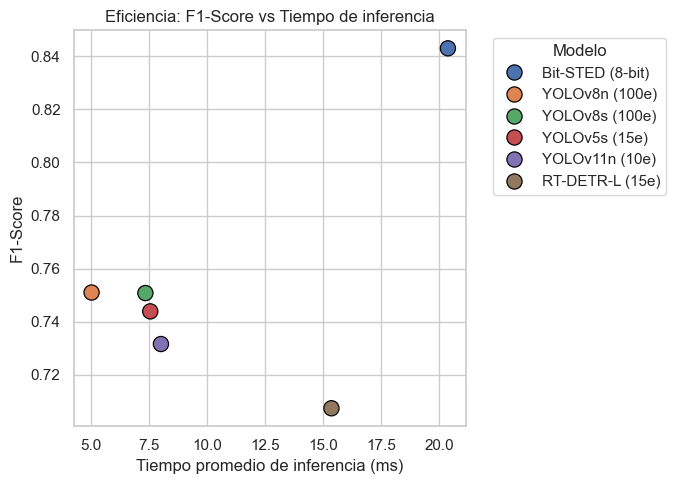

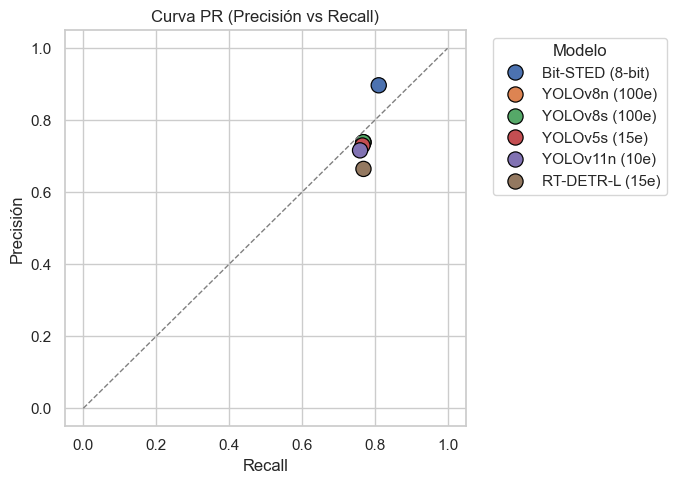

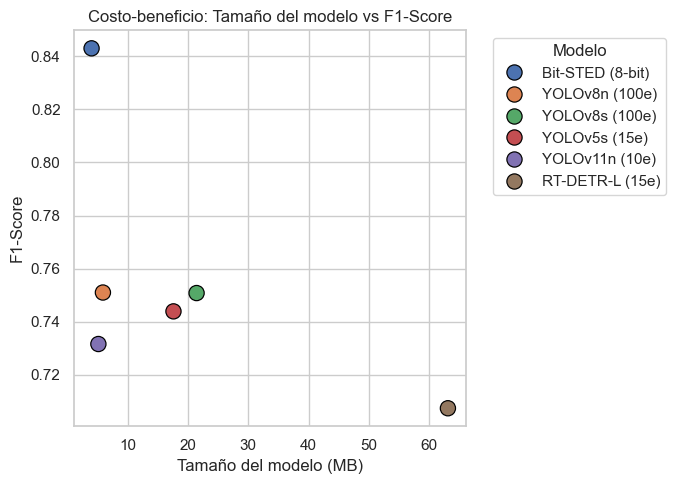

C:\Users\BSG\AppData\Local\Temp\ipykernel_33676\2947608362.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


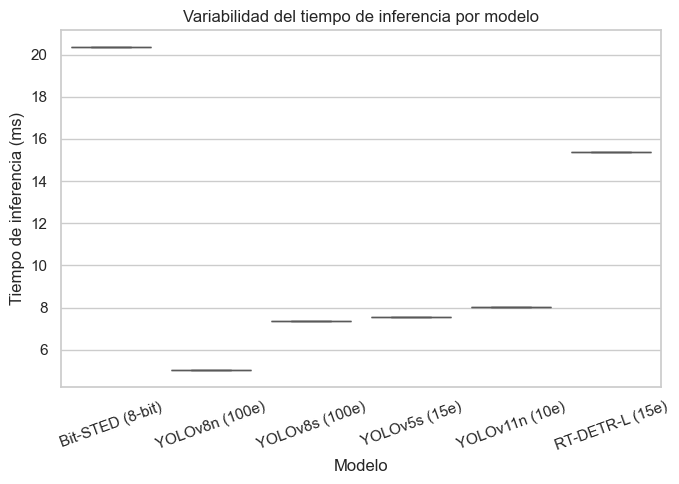

In [ ]:
# Configuración general de estilo
sns.set(style="whitegrid", context="notebook")

# Validación de existencia del DataFrame
if 'df_metricas' not in locals():
    raise ValueError("No se encontró el DataFrame 'df_metricas'. Ejecuta primero la celda de evaluación comparativa.")

# Renombrar columnas para consistencia interna
df_plot = df_metricas.rename(columns={
    "F1-Score": "F1",
    "Tiempo Promedio (ms)": "Tiempo_inferencia_ms",
    "Tamaño (MB)": "Tamaño_MB"
})

# ------------------------------------------------
# Gráfica 1: F1-Score vs Tiempo de inferencia
# ------------------------------------------------
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_plot,
    x="Tiempo_inferencia_ms",
    y="F1",
    hue="Modelo",
    s=120,
    edgecolor="black"
)
plt.title("Eficiencia: F1-Score vs Tiempo de inferencia", fontsize=12)
plt.xlabel("Tiempo promedio de inferencia (ms)")
plt.ylabel("F1-Score")
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Gráfica 2: Precisión vs Recall (Curva PR)
# ------------------------------------------------
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_plot,
    x="Recall",
    y="Precisión",
    hue="Modelo",
    s=120,
    edgecolor="black"
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1)
plt.title("Curva PR (Precisión vs Recall)", fontsize=12)
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Gráfica 3: Tamaño del modelo vs F1-Score
# ------------------------------------------------
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_plot,
    x="Tamaño_MB",
    y="F1",
    hue="Modelo",
    s=120,
    edgecolor="black"
)
plt.title("Costo-beneficio: Tamaño del modelo vs F1-Score", fontsize=12)
plt.xlabel("Tamaño del modelo (MB)")
plt.ylabel("F1-Score")
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Gráfica 4: Boxplot del tiempo de inferencia
# ------------------------------------------------
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=df_plot,
    x="Modelo",
    y="Tiempo_inferencia_ms",
    palette="Set2"
)
plt.title("Variabilidad del tiempo de inferencia por modelo", fontsize=12)
plt.xlabel("Modelo")
plt.ylabel("Tiempo de inferencia (ms)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

El modelo Bit-STED demostró ser el más eficiente para tareas de visión computacional en entornos con recursos limitados, como una Raspberry Pi 5. En la primera gráfica, que compara el F1-Score con el tiempo de inferencia, Bit-STED alcanzó el mayor rendimiento en precisión, aunque con un tiempo de procesamiento algo mayor que los modelos YOLOv5s y YOLOv8n, los cuales fueron más rápidos pero con menor F1-Score. La segunda gráfica, que muestra la relación entre precisión y recall, evidenció que Bit-STED mantiene un buen equilibrio entre ambos indicadores, mientras que los modelos YOLO tuvieron un desempeño aceptable pero menos consistente. En la tercera gráfica, que analiza el tamaño del modelo frente al F1-Score, Bit-STED sobresalió por combinar un alto rendimiento con el menor tamaño, en contraste con modelos como RT-DETR, que mostraron bajo rendimiento y un tamaño considerablemente mayor. Finalmente, en la gráfica de boxplot sobre el tiempo de inferencia, los modelos YOLO demostraron ser más rápidos y con tiempos más estables, lo que puede ser ventajoso para aplicaciones en tiempo real, aunque sacrifican precisión. En conjunto, los resultados posicionan a Bit-STED como una solución sólida, precisa y eficiente para la detección automática de agaves en campo, mientras que los modelos YOLO representan una alternativa válida cuando la velocidad es prioritaria y se puede tolerar una menor precisión.

Conclusion

Con base en los resultados cuantitativos, las gráficas de rendimiento y el análisis visual, se puede concluir que el modelo Bit-STED es el que ofrece el mejor desempeño general entre los seis evaluados para la detección automática de plantas de agave en imágenes aéreas. Destaca por su alta precisión de aproximadamente 0.897 y el mayor F1-Score registrado, de 0.843, además de ser el modelo más ligero con solo 4.04 MB, lo que lo convierte en una excelente opción para plataformas embebidas con recursos limitados, como la Raspberry Pi 5. Sin embargo, su tiempo de inferencia, que supera los 20 milisegundos, puede representar una limitación en aplicaciones que requieren respuesta en tiempo real.

Por su parte, los modelos YOLOv8 Small, YOLOv5 Small y YOLOv11 Nano mostraron un rendimiento muy similar entre sí, logrando un buen equilibrio entre precisión, recall y eficiencia. Estos modelos mantienen tiempos de inferencia bajos, entre 5 y 8 milisegundos, y ofrecieron resultados consistentes en el análisis visual, por lo que son opciones viables para tareas en tiempo real en entornos con capacidad de cómputo moderada. RT-DETR, si bien tuvo menor precisión, presentó un comportamiento estable y predecible, lo que lo hace útil en escenarios donde la consistencia es más relevante que la exactitud máxima. En contraste, YOLOv8 Nano mostró los resultados más modestos tanto en métricas como en la calidad de las detecciones visuales, lo que sugiere que su bajo peso puede afectar la calidad de las predicciones en condiciones reales de campo.

En resumen, Bit-STED ofrece el mejor balance entre precisión, tamaño y rendimiento, siendo especialmente adecuado para aplicaciones donde la calidad de detección es prioritaria. Los modelos YOLO pequeños representan alternativas eficaces cuando se busca mayor velocidad y eficiencia computacional, aceptando un sacrificio moderado en precisión. La elección final del modelo dependerá de los requisitos específicos del caso de uso, especialmente en términos de exactitud, velocidad y recursos disponibles en el hardware de destino.